# Problem 1: MNIST

The code for this multilayer perceptron can be found in `mnist.py`. The module `utils.py` contains helper functions to load the dataset, display progress bar, plot graphs, etc.

In [2]:
import sys
sys.path.append('../src/')
from mnist_v2 import *

---
## Building the Model

We build an MLP and choose the values of $h^1$ and $h^2$ such that the total number of parameters (including biases) falls within the range of $I = [0.5M, 1.0M]$. This can be achieved by choosing $h^1 = h^2 = 512$. Since MNIST samples are $28 \times 28 = 784$ pixels, the total number of parameters is

In [ ]:
num_params = (28*28)*512 + 512*512 + 512*10
print(num_params)

which is within range. We thus build the MLP with the parameters below.

In [3]:
# Initialize parameters
layers = [784, 512, 512, 10]
learning_rate = 1e-2
batch_size = 64
data_filename = "../data/mnist/mnist.pkl"

We now load the tensors via Torch data loaders.

In [4]:
train_loader, valid_loader, test_loader = get_data_loaders(data_filename, batch_size)

---
## Initialization

Hardcoded parameters used for all three initilization schemes are:
* **Activation functions:** Rectified linear unit (ReLU)
* **Loss function:** Cross entropy
* **Optimizer:** Stochastic gradient descent (SGD) with learning rate `learning_rate`

For each initialization scheme, we compile the model and train by keeping track of the average loss. After training, we plot the result.

### Zeros

In [5]:
# Compile and train model
mlp_z = MNIST(layers, learning_rate, "zeros")
zeros_losses = mlp_z.train(2, train_loader, [], [], len(train_loader.dataset))[0]

Epoch 1/2
Avg loss: 2.3019 -- Train acc: 0.1135% 
Epoch 2/2
Avg loss: 2.3012 -- Train acc: 0.1135% 
Training done! Elapsed time: 0:00:12



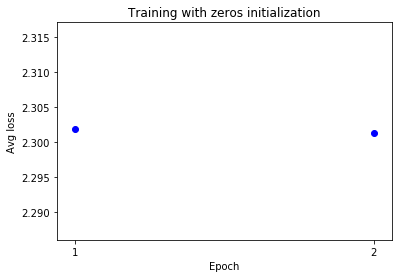

In [6]:
# Plot avg loss / epoch
%matplotlib inline
plot_per_epoch(zeros_losses, "Avg loss", "Training with zeros initialization")

### Normal

In [5]:
# Compile and train model
mlp_n = MNIST(layers, learning_rate, "normal")
normal_losses = mlp_n.train(1, train_loader, [], [], len(train_loader.dataset))[0]

Epoch 1/1
Avg loss: 99.3026 -- Train acc: 0.9392 
Training done! Elapsed time: 0:00:06



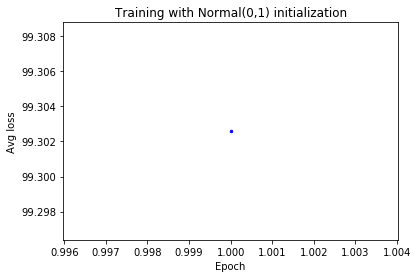

In [7]:
# Plot avg loss / epoch
%matplotlib inline
plot_per_epoch(normal_losses, "Avg loss", "Training with Normal(0,1) initialization")

### Glorot

In [19]:
# Compile and train model
mlp_g = MNIST(layers, learning_rate, "glorot")
glorot_losses = mlp_g.train(3, train_loader, [], [], len(train_loader.dataset))[0]

Epoch 1/3
Avg loss: 0.8777 -- Train acc: 0.8801% 
Epoch 2/3
Avg loss: 0.3686 -- Train acc: 0.9060% 
Epoch 3/3
Avg loss: 0.3056 -- Train acc: 0.9186% 
Training done! Elapsed time: 0:00:18



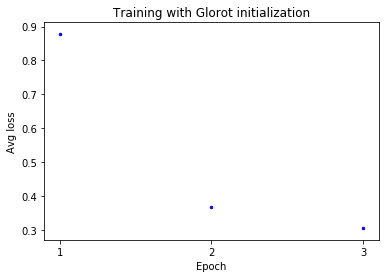

In [20]:
# Plot avg loss / epoch
%matplotlib inline
plot_per_epoch(glorot_losses, "Avg loss", "Training with Glorot initialization")

---
## Learning Curves

In [11]:
mlp = MNIST(layers, learning_rate, "glorot")
_, train_acc, valid_acc, _ = mlp.train(1, train_loader, valid_loader, [], len(train_loader.dataset))

Epoch 1/1
Avg loss: 0.8607 -- Train acc: 0.8847 -- Val acc: 0.8935
Training done! Elapsed time: 0:00:06



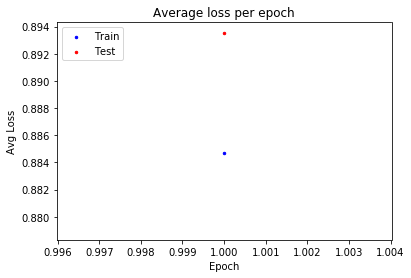

In [15]:
# Plot training and test accuracy / epoch
plots_per_epoch([train_acc, valid_acc], ["Train", "Test"], "Avg Loss", "Average loss per epoch")

We now train by doubling the model capacity. This is done by doubling the number of neurons at each layer.

In [ ]:
num_params = (28*28)*2*512 + 2*512*512 + 512*10
print(num_params)

In [12]:
layers_2 = [784, 2*512, 2*512, 10]
mlp_2 = MNIST(layers_2, learning_rate, "glorot")
train_acc_2, _, valid_acc_2, _ = mlp_2.train(1, train_loader, valid_loader, [], len(train_loader.dataset))

Epoch 1/1
Avg loss: 0.8248 -- Train acc: 0.8886 -- Val acc: 0.8973
Training done! Elapsed time: 0:00:13



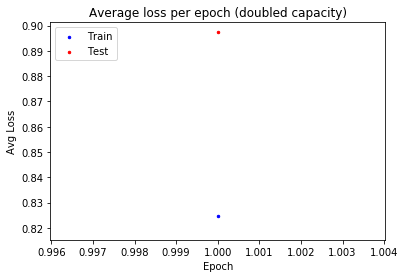

In [14]:
# Plot training and test accuracy / epoch
plots_per_epoch([train_acc_2, valid_acc_2], ["Train", "Test"], "Avg Loss", "Average loss per epoch (doubled capacity)")

---
## Training Set Size, Generalization Gap, and Standard Error

For each ratio $a \in \{0.01, 0.02, 0.05, 0.1, 1.0\}$, we reduce the training set to $N_a = aN$ samples, where $N= 50\,000$. We then train using this new dataset.

In [18]:
# Initialize best model so far
mlp = MNIST(layers, learning_rate, "glorot")
ratios = [0.01, 0.02, 0.05, 0.1, 1.0]
nb_epochs = 1
nb_trials = 3

# Generalization gaps
Ga = np.zeros((len(ratios), nb_trials, nb_epochs))
             
for i, a in enumerate(ratios):
    length = int(a * len(train_loader.dataset))
    print("%s\na = %.2f, Na = %d\n%s" % ("="*30, a, length, "-"*30))
    
    for j in range(nb_trials):
        print("Iter %s" % str(j + 1))
        # Subsample from training set
        Na, sub_train_loader = subsample_train(a, train_loader, batch_size)
    
        # Train
        train_loss, train_acc, valid_acc, test_acc = \
            mlp.train(nb_epochs, sub_train_loader, valid_loader, test_loader, Na, gen_gap=True)
        
        # Save generalization gap
        Ga[i,j,:] = [r_train - r_test for r_train, r_test in zip(train_acc, test_acc)]

a = 0.01, Na = 500
------------------------------
Iter 1
Epoch 1/1
Avg loss: 2.3068 -- Train acc: 0.1406 -- Val acc: 0.1357 -- Test acc: 0.1259 -- Gen gap 0.0147
Training done! Elapsed time: 0:00:00

Iter 2
Epoch 1/1
Avg loss: 2.2417 -- Train acc: 0.2773 -- Val acc: 0.2367 -- Test acc: 0.2275 -- Gen gap 0.0498
Training done! Elapsed time: 0:00:00

Iter 3
Epoch 1/1
Avg loss: 2.1908 -- Train acc: 0.3340 -- Val acc: 0.3134 -- Test acc: 0.3058 -- Gen gap 0.0282
Training done! Elapsed time: 0:00:00

a = 0.02, Na = 1000
------------------------------
Iter 1
Epoch 1/1
Avg loss: 2.1064 -- Train acc: 0.4736 -- Val acc: 0.5063 -- Test acc: 0.4858 -- Gen gap -0.0121
Training done! Elapsed time: 0:00:00

Iter 2
Epoch 1/1
Avg loss: 1.9937 -- Train acc: 0.5850 -- Val acc: 0.6057 -- Test acc: 0.5785 -- Gen gap 0.0064
Training done! Elapsed time: 0:00:00

Iter 3
Epoch 1/1
Avg loss: 1.8756 -- Train acc: 0.6924 -- Val acc: 0.7055 -- Test acc: 0.6843 -- Gen gap 0.0081
Training done! Elapsed time: 0:00:00